In [1]:
import os
import torch
from tqdm import tqdm
from utils import Classification_Model, Standard_DataLoader, Trainer, load_rgb_mean_std

In [2]:
CWD = os.getcwd()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE_NAME = torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'

print(f"CWD: {CWD}")
print(f"DEVICE: {DEVICE_NAME}")

CWD: /mnt/e/xAI-WriterIdentification/HI-EXP/classifier_NN
DEVICE: NVIDIA GeForce RTX 3060


In [6]:
MODEL_PATH = CWD + "/cp/Test_3_TL_val_best_model.pth"
TEST_ID = "CVL-0001"
OUTPUT_DIR = CWD + f"/tests/output/{TEST_ID}"
SOURCE_DATA_DIR = CWD + "/../../datasets/CVL_Pages"

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

# Phase 1 -> Dataset Splitting

In [9]:
pages = os.listdir(SOURCE_DATA_DIR)
os.mkdir(OUTPUT_DIR + "/train")
os.mkdir(OUTPUT_DIR + "/val")
os.mkdir(OUTPUT_DIR + "/test")
for i in tqdm(range(0, len(pages)), desc="Splitting Dataset"):
    p = pages[i]
    writer_id = p.split("-")[0]
    page_id = int(p.split("-")[1])

    if writer_id in ['0052', '0190', '0384', '0400', '0602', '0717', '1122']:

        if not os.path.exists(OUTPUT_DIR + f"/train/{writer_id}"):
            os.mkdir(OUTPUT_DIR + f"/train/{writer_id}")
        if not os.path.exists(OUTPUT_DIR + f"/val/{writer_id}"):
            os.mkdir(OUTPUT_DIR + f"/val/{writer_id}")
        if not os.path.exists(OUTPUT_DIR + f"/test/{writer_id}"):
            os.mkdir(OUTPUT_DIR + f"/test/{writer_id}")
    
        if page_id in [1,3,4]:          # Train Pages
            os.system(f"cp " + SOURCE_DATA_DIR + f"/{p} " + OUTPUT_DIR + f"/train/{writer_id}/{p}")
        elif page_id == 2:              # Validation Pages
            os.system(f"cp " + SOURCE_DATA_DIR + f"/{p} " + OUTPUT_DIR + f"/val/{writer_id}/{p}")
        elif page_id == 6:              # Test Pages
            os.system(f"cp " + SOURCE_DATA_DIR + f"/{p} " + OUTPUT_DIR + f"/test/{writer_id}/{p}")
        else:
            continue

Splitting Dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1604/1604 [00:02<00:00, 664.35it/s]


# Phase 2 -> System Fine-Tuning

In [10]:
num_classes = len(os.listdir(OUTPUT_DIR + "/train"))
model = Classification_Model(num_classes=num_classes, mode='frozen', cp_path=MODEL_PATH)
model = model.to(DEVICE)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Number of trainable parameters: {pytorch_total_params}')

Number of trainable parameters: 33095


In [11]:
mean_, std_ = load_rgb_mean_std(f"{OUTPUT_DIR}/train")
train_ds = Standard_DataLoader(directory=f"{OUTPUT_DIR}/train", batch_size=32, weighted_sampling=True, phase='train', mean=mean_, std=std_, shuffle=True)
val_ds = Standard_DataLoader(directory=f"{OUTPUT_DIR}/val", batch_size=32, weighted_sampling=False, phase='val', mean=mean_, std=std_, shuffle=False)
tds, t_dl = train_ds.load_data()
vds, v_dl = val_ds.load_data()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  5.34it/s]


In [13]:
os.mkdir(f"{OUTPUT_DIR}/checkpoints")
torch.backends.cudnn.benchmark = True
trainer = Trainer(model=model, t_set=t_dl, v_set=v_dl, DEVICE=DEVICE, optim_type='adamw', lr_=0.02, 
                  model_path=OUTPUT_DIR, history_path=OUTPUT_DIR, test_ID=TEST_ID, num_epochs=100)
trainer()

Epoch 1 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


train_loss: 2.0330810546875 - train_accuracy: 0.09523809523809523



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


val_loss: 11.909485816955566 - val_accuracy: 0.14285714285714285

Epoch 2 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


train_loss: 1.9193347692489624 - train_accuracy: 0.2857142857142857



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


val_loss: 6.377640724182129 - val_accuracy: 0.14285714285714285

Epoch 3 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


train_loss: 1.9819103479385376 - train_accuracy: 0.19047619047619047



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


val_loss: 6.754240989685059 - val_accuracy: 0.14285714285714285

Epoch 4 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


train_loss: 2.0849552154541016 - train_accuracy: 0.2857142857142857



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


val_loss: 6.543918132781982 - val_accuracy: 0.14285714285714285

Epoch 5 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


train_loss: 1.9537996053695679 - train_accuracy: 0.19047619047619047



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


val_loss: 6.280282497406006 - val_accuracy: 0.14285714285714285

Epoch 6 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


train_loss: 1.8629884719848633 - train_accuracy: 0.2857142857142857



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


val_loss: 5.420554161071777 - val_accuracy: 0.14285714285714285

Epoch 7 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


train_loss: 1.8091212511062622 - train_accuracy: 0.2857142857142857



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


val_loss: 5.333861351013184 - val_accuracy: 0.0

Epoch 8 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


train_loss: 1.7587969303131104 - train_accuracy: 0.47619047619047616



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


val_loss: 4.270407199859619 - val_accuracy: 0.2857142857142857

Epoch 9 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


train_loss: 1.9651445150375366 - train_accuracy: 0.14285714285714285



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


val_loss: 4.495540618896484 - val_accuracy: 0.2857142857142857

Epoch 10 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


train_loss: 1.940894365310669 - train_accuracy: 0.23809523809523808



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


val_loss: 4.282086372375488 - val_accuracy: 0.14285714285714285

Epoch 11 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


train_loss: 1.998971700668335 - train_accuracy: 0.19047619047619047



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


val_loss: 4.033143520355225 - val_accuracy: 0.14285714285714285

Epoch 12 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


train_loss: 1.8553032875061035 - train_accuracy: 0.38095238095238093



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


val_loss: 4.147207736968994 - val_accuracy: 0.14285714285714285

Epoch 13 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


train_loss: 1.9791814088821411 - train_accuracy: 0.14285714285714285



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


val_loss: 4.468441963195801 - val_accuracy: 0.14285714285714285

Epoch 14 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


train_loss: 1.7761021852493286 - train_accuracy: 0.3333333333333333



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


val_loss: 4.440488815307617 - val_accuracy: 0.14285714285714285

Epoch 15 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


train_loss: 1.8267689943313599 - train_accuracy: 0.14285714285714285



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


val_loss: 4.3745436668396 - val_accuracy: 0.14285714285714285

Epoch 16 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


train_loss: 2.074608564376831 - train_accuracy: 0.23809523809523808



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


val_loss: 3.8676869869232178 - val_accuracy: 0.14285714285714285

Epoch 17 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.80s/it]


train_loss: 2.028764486312866 - train_accuracy: 0.14285714285714285



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


val_loss: 3.5918095111846924 - val_accuracy: 0.14285714285714285

Epoch 18 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


train_loss: 1.887251853942871 - train_accuracy: 0.19047619047619047



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


val_loss: 3.106963872909546 - val_accuracy: 0.14285714285714285

Epoch 19 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


train_loss: 2.1176884174346924 - train_accuracy: 0.14285714285714285



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


val_loss: 2.4717204570770264 - val_accuracy: 0.14285714285714285

Epoch 20 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


train_loss: 2.0512616634368896 - train_accuracy: 0.23809523809523808



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


val_loss: 2.47650146484375 - val_accuracy: 0.14285714285714285

Epoch 21 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


train_loss: 1.8430368900299072 - train_accuracy: 0.23809523809523808



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


val_loss: 2.046410083770752 - val_accuracy: 0.14285714285714285

Epoch 22 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


train_loss: 1.8281805515289307 - train_accuracy: 0.2857142857142857



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


val_loss: 2.216109037399292 - val_accuracy: 0.14285714285714285

Epoch 23 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


train_loss: 1.696857213973999 - train_accuracy: 0.47619047619047616



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


val_loss: 1.9795395135879517 - val_accuracy: 0.42857142857142855

Epoch 24 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


train_loss: 1.9173836708068848 - train_accuracy: 0.23809523809523808



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


val_loss: 2.3363897800445557 - val_accuracy: 0.14285714285714285

Epoch 25 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


train_loss: 1.97654128074646 - train_accuracy: 0.19047619047619047



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


val_loss: 2.893644094467163 - val_accuracy: 0.14285714285714285

Epoch 26 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


train_loss: 1.7808910608291626 - train_accuracy: 0.2857142857142857



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


val_loss: 3.509960174560547 - val_accuracy: 0.14285714285714285

Epoch 27 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


train_loss: 1.8634446859359741 - train_accuracy: 0.09523809523809523



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


val_loss: 3.6083319187164307 - val_accuracy: 0.14285714285714285

Epoch 28 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


train_loss: 1.9786227941513062 - train_accuracy: 0.23809523809523808



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


val_loss: 3.1948506832122803 - val_accuracy: 0.14285714285714285

Epoch 29 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


train_loss: 2.0281877517700195 - train_accuracy: 0.14285714285714285



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


val_loss: 2.6876988410949707 - val_accuracy: 0.14285714285714285

Epoch 30 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


train_loss: 1.77158522605896 - train_accuracy: 0.38095238095238093



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


val_loss: 2.1336352825164795 - val_accuracy: 0.14285714285714285

Epoch 31 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


train_loss: 2.1152682304382324 - train_accuracy: 0.09523809523809523



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


val_loss: 1.933656930923462 - val_accuracy: 0.2857142857142857

Epoch 32 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


train_loss: 1.9488645792007446 - train_accuracy: 0.19047619047619047



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


val_loss: 2.139849901199341 - val_accuracy: 0.2857142857142857

Epoch 33 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


train_loss: 1.822995901107788 - train_accuracy: 0.2857142857142857



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


val_loss: 2.3416659832000732 - val_accuracy: 0.0

Epoch 34 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


train_loss: 1.8200173377990723 - train_accuracy: 0.2857142857142857



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


val_loss: 2.260983943939209 - val_accuracy: 0.14285714285714285

Epoch 35 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


train_loss: 1.9710440635681152 - train_accuracy: 0.19047619047619047



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


val_loss: 2.1240153312683105 - val_accuracy: 0.14285714285714285

Epoch 36 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


train_loss: 1.8169070482254028 - train_accuracy: 0.2857142857142857



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


val_loss: 2.211347818374634 - val_accuracy: 0.14285714285714285

Epoch 37 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


train_loss: 1.8899372816085815 - train_accuracy: 0.23809523809523808



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


val_loss: 2.1560986042022705 - val_accuracy: 0.2857142857142857

Epoch 38 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


train_loss: 1.8840984106063843 - train_accuracy: 0.14285714285714285



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


val_loss: 2.276563882827759 - val_accuracy: 0.14285714285714285

Epoch 39 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


train_loss: 2.0747005939483643 - train_accuracy: 0.19047619047619047



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


val_loss: 2.0005414485931396 - val_accuracy: 0.2857142857142857

Epoch 40 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


train_loss: 1.698660135269165 - train_accuracy: 0.3333333333333333



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


val_loss: 1.9318326711654663 - val_accuracy: 0.2857142857142857

Epoch 41 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


train_loss: 1.6661218404769897 - train_accuracy: 0.2857142857142857



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


val_loss: 1.8865547180175781 - val_accuracy: 0.14285714285714285

Epoch 42 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


train_loss: 1.8660601377487183 - train_accuracy: 0.14285714285714285



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


val_loss: 1.8782294988632202 - val_accuracy: 0.2857142857142857

Epoch 43 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


train_loss: 1.9449084997177124 - train_accuracy: 0.09523809523809523



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


val_loss: 1.997132658958435 - val_accuracy: 0.14285714285714285

Epoch 44 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


train_loss: 1.958460807800293 - train_accuracy: 0.14285714285714285



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


val_loss: 2.104903221130371 - val_accuracy: 0.14285714285714285

Epoch 45 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


train_loss: 1.7427597045898438 - train_accuracy: 0.2857142857142857



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


val_loss: 1.98894202709198 - val_accuracy: 0.14285714285714285

Epoch 46 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


train_loss: 1.633050799369812 - train_accuracy: 0.3333333333333333



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


val_loss: 1.8820171356201172 - val_accuracy: 0.14285714285714285

Epoch 47 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


train_loss: 1.8958631753921509 - train_accuracy: 0.09523809523809523



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


val_loss: 1.9606143236160278 - val_accuracy: 0.2857142857142857

Epoch 48 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


train_loss: 1.900974988937378 - train_accuracy: 0.19047619047619047



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


val_loss: 1.9490432739257812 - val_accuracy: 0.14285714285714285

Epoch 49 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


train_loss: 1.7740072011947632 - train_accuracy: 0.3333333333333333



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


val_loss: 1.93386971950531 - val_accuracy: 0.14285714285714285

Epoch 50 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


train_loss: 1.8826944828033447 - train_accuracy: 0.19047619047619047



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


val_loss: 1.784956932067871 - val_accuracy: 0.2857142857142857

Epoch 51 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


train_loss: 1.8259027004241943 - train_accuracy: 0.2857142857142857



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


val_loss: 1.8629090785980225 - val_accuracy: 0.2857142857142857

Epoch 52 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


train_loss: 1.9506139755249023 - train_accuracy: 0.2857142857142857



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


val_loss: 1.841562271118164 - val_accuracy: 0.2857142857142857

Epoch 53 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


train_loss: 1.909617304801941 - train_accuracy: 0.3333333333333333



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


val_loss: 1.956135630607605 - val_accuracy: 0.2857142857142857

Epoch 54 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


train_loss: 1.525269627571106 - train_accuracy: 0.6190476190476191



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


val_loss: 2.11092209815979 - val_accuracy: 0.14285714285714285

Epoch 55 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


train_loss: 1.7116998434066772 - train_accuracy: 0.19047619047619047



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


val_loss: 2.0534913539886475 - val_accuracy: 0.2857142857142857

Epoch 56 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


train_loss: 1.5902719497680664 - train_accuracy: 0.38095238095238093



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


val_loss: 2.2650325298309326 - val_accuracy: 0.14285714285714285

Epoch 57 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


train_loss: 1.8373947143554688 - train_accuracy: 0.23809523809523808



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


val_loss: 2.8621065616607666 - val_accuracy: 0.14285714285714285

Epoch 58 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


train_loss: 1.7110941410064697 - train_accuracy: 0.23809523809523808



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


val_loss: 3.4858059883117676 - val_accuracy: 0.14285714285714285

Epoch 59 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]


train_loss: 1.5418882369995117 - train_accuracy: 0.47619047619047616



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


val_loss: 4.934744834899902 - val_accuracy: 0.14285714285714285

Epoch 60 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


train_loss: 1.6164765357971191 - train_accuracy: 0.42857142857142855



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


val_loss: 4.188075542449951 - val_accuracy: 0.14285714285714285

Epoch 61 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


train_loss: 1.9895349740982056 - train_accuracy: 0.19047619047619047



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


val_loss: 4.172121524810791 - val_accuracy: 0.14285714285714285

Epoch 62 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


train_loss: 1.6552598476409912 - train_accuracy: 0.47619047619047616



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


val_loss: 4.074944496154785 - val_accuracy: 0.14285714285714285

Epoch 63 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


train_loss: 1.6792409420013428 - train_accuracy: 0.38095238095238093



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


val_loss: 3.8557047843933105 - val_accuracy: 0.14285714285714285

Epoch 64 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


train_loss: 2.105781078338623 - train_accuracy: 0.19047619047619047



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


val_loss: 3.6283271312713623 - val_accuracy: 0.14285714285714285

Epoch 65 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


train_loss: 1.6938244104385376 - train_accuracy: 0.38095238095238093



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


val_loss: 2.881298542022705 - val_accuracy: 0.14285714285714285

Epoch 66 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


train_loss: 1.8177802562713623 - train_accuracy: 0.3333333333333333



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


val_loss: 2.234356164932251 - val_accuracy: 0.14285714285714285

Epoch 67 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


train_loss: 1.7528578042984009 - train_accuracy: 0.38095238095238093



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


val_loss: 1.8946847915649414 - val_accuracy: 0.14285714285714285

Epoch 68 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


train_loss: 1.5494401454925537 - train_accuracy: 0.5238095238095238



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


val_loss: 1.8540446758270264 - val_accuracy: 0.2857142857142857

Epoch 69 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


train_loss: 1.6604036092758179 - train_accuracy: 0.2857142857142857



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


val_loss: 1.7815371751785278 - val_accuracy: 0.2857142857142857

Epoch 70 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


train_loss: 1.9426565170288086 - train_accuracy: 0.09523809523809523



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


val_loss: 2.198869466781616 - val_accuracy: 0.2857142857142857

Epoch 71 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


train_loss: 2.0894923210144043 - train_accuracy: 0.14285714285714285



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


val_loss: 2.28704571723938 - val_accuracy: 0.2857142857142857

Epoch 72 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


train_loss: 2.001450777053833 - train_accuracy: 0.19047619047619047



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


val_loss: 2.4516568183898926 - val_accuracy: 0.2857142857142857

Epoch 73 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


train_loss: 1.8353627920150757 - train_accuracy: 0.19047619047619047



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


val_loss: 2.36106276512146 - val_accuracy: 0.2857142857142857

Epoch 74 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


train_loss: 2.3234615325927734 - train_accuracy: 0.09523809523809523



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


val_loss: 1.9207782745361328 - val_accuracy: 0.42857142857142855

Epoch 75 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


train_loss: 1.7563972473144531 - train_accuracy: 0.14285714285714285



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


val_loss: 1.943603515625 - val_accuracy: 0.2857142857142857

Epoch 76 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


train_loss: 1.844285488128662 - train_accuracy: 0.3333333333333333



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


val_loss: 2.2765488624572754 - val_accuracy: 0.14285714285714285

Epoch 77 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


train_loss: 1.7174357175827026 - train_accuracy: 0.5238095238095238



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


val_loss: 2.5269906520843506 - val_accuracy: 0.14285714285714285

Epoch 78 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


train_loss: 1.8744995594024658 - train_accuracy: 0.2857142857142857



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


val_loss: 3.307992935180664 - val_accuracy: 0.14285714285714285

Epoch 79 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/it]


train_loss: 1.5872095823287964 - train_accuracy: 0.3333333333333333



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


val_loss: 3.919177532196045 - val_accuracy: 0.14285714285714285

Epoch 80 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


train_loss: 1.6141208410263062 - train_accuracy: 0.3333333333333333



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


val_loss: 3.954127073287964 - val_accuracy: 0.14285714285714285

Epoch 81 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


train_loss: 1.6783201694488525 - train_accuracy: 0.3333333333333333



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


val_loss: 3.777021884918213 - val_accuracy: 0.14285714285714285

Epoch 82 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


train_loss: 1.6660559177398682 - train_accuracy: 0.19047619047619047



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


val_loss: 3.01226806640625 - val_accuracy: 0.14285714285714285

Epoch 83 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


train_loss: 1.7064392566680908 - train_accuracy: 0.38095238095238093



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


val_loss: 2.812317371368408 - val_accuracy: 0.14285714285714285

Epoch 84 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


train_loss: 1.619310975074768 - train_accuracy: 0.3333333333333333



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


val_loss: 2.561891794204712 - val_accuracy: 0.14285714285714285

Epoch 85 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


train_loss: 1.6462323665618896 - train_accuracy: 0.42857142857142855



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


val_loss: 2.3012006282806396 - val_accuracy: 0.14285714285714285

Epoch 86 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


train_loss: 2.0065205097198486 - train_accuracy: 0.14285714285714285



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


val_loss: 1.8933274745941162 - val_accuracy: 0.14285714285714285

Epoch 87 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


train_loss: 1.8557329177856445 - train_accuracy: 0.2857142857142857



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


val_loss: 1.9145596027374268 - val_accuracy: 0.2857142857142857

Epoch 88 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


train_loss: 1.7612645626068115 - train_accuracy: 0.23809523809523808



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


val_loss: 1.810684084892273 - val_accuracy: 0.2857142857142857

Epoch 89 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


train_loss: 1.8056633472442627 - train_accuracy: 0.38095238095238093



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


val_loss: 2.0221047401428223 - val_accuracy: 0.14285714285714285

Epoch 90 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


train_loss: 1.7424070835113525 - train_accuracy: 0.19047619047619047



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


val_loss: 1.9490244388580322 - val_accuracy: 0.2857142857142857

Epoch 91 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


train_loss: 1.62644362449646 - train_accuracy: 0.3333333333333333



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


val_loss: 2.035550832748413 - val_accuracy: 0.2857142857142857

Epoch 92 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


train_loss: 1.669287919998169 - train_accuracy: 0.3333333333333333



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


val_loss: 2.1617531776428223 - val_accuracy: 0.14285714285714285

Epoch 93 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


train_loss: 1.5385794639587402 - train_accuracy: 0.5238095238095238



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


val_loss: 2.699857711791992 - val_accuracy: 0.2857142857142857

Epoch 94 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


train_loss: 1.905243992805481 - train_accuracy: 0.23809523809523808



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


val_loss: 2.319298267364502 - val_accuracy: 0.2857142857142857

Epoch 95 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


train_loss: 1.5033165216445923 - train_accuracy: 0.42857142857142855



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


val_loss: 2.3729605674743652 - val_accuracy: 0.14285714285714285

Epoch 96 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


train_loss: 1.6381402015686035 - train_accuracy: 0.23809523809523808



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


val_loss: 1.8929624557495117 - val_accuracy: 0.2857142857142857

Epoch 97 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


train_loss: 1.5385807752609253 - train_accuracy: 0.47619047619047616



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


val_loss: 2.1435306072235107 - val_accuracy: 0.2857142857142857

Epoch 98 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


train_loss: 1.7509034872055054 - train_accuracy: 0.23809523809523808



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


val_loss: 2.143709182739258 - val_accuracy: 0.14285714285714285

Epoch 99 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


train_loss: 1.5511280298233032 - train_accuracy: 0.47619047619047616



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


val_loss: 2.374391794204712 - val_accuracy: 0.14285714285714285

Epoch 100 / 100


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


train_loss: 1.6583664417266846 - train_accuracy: 0.2857142857142857



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]

val_loss: 2.7704219818115234 - val_accuracy: 0.14285714285714285



# Phase 3 -> Print Results for Training -> Phase 3

In [14]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

In [15]:
losses = {'train': [], 'val': []}
accs = {'train': [], 'val': []}

In [16]:
for loss in list(losses.keys()):
    with open(f'{OUTPUT_DIR}/Test_{TEST_ID}_MLC_{loss}_losses.pkl', 'rb') as f:
        losses[loss] = pkl.load(f)

In [17]:
with open(f'{OUTPUT_DIR}/Test_{TEST_ID}_MLC_losses.txt', 'w') as f:
    f.write('The optimal value of loss for the training set is: {:01.3f}\n'.format(np.min(losses['train'])))
    f.write('The optimal value of loss for the validation set is: {:01.3f}\n'.format(np.min(losses['val'])))
    best_epoch_train = np.where(np.array(losses['train']) == min(losses['train']))[0][0] + 1
    best_epoch = np.where(np.array(losses['val']) == min(losses['val']))[0][0] + 1
    f.write(f"Epoch corresponding to the optimal value of the training loss: {best_epoch_train}\\{len(losses['train'])}\n")
    f.write(f"Epoch corresponding to the optimal value of the validation loss: {best_epoch}\\{len(losses['val'])}\n")

In [18]:
plt.plot(losses['train'])
plt.plot(losses['val'])
plt.title('Model loss')
plt.ylabel('Loss [-]')
plt.xlabel('Epoch [-]')
plt.legend(['Training', 'Validation'], loc='best')
plt.savefig(f'{OUTPUT_DIR}/Test_{TEST_ID}_MLC_losses.png')
plt.close()

In [19]:
for acc in list(accs.keys()):
    with open(f'{OUTPUT_DIR}/Test_{TEST_ID}_MLC_{acc}_accuracy.pkl', 'rb') as f:
        accs[acc] = pkl.load(f)

In [20]:
with open(f'{OUTPUT_DIR}/Test_{TEST_ID}_MLC_accuracy.txt', 'w') as f:
    f.write('The optimal value of accuracy for the training set is: {:01.3f}\n'.format(np.max(accs['train'])))
    f.write('The optimal value of accuracy for the validation set is: {:01.3f}\n'.format(np.max(accs['val'])))
    best_epoch_train = np.where(np.array(accs['train']) == max(accs['train']))[0][0] + 1
    best_epoch = np.where(np.array(accs['val']) == max(accs['val']))[0][0] + 1
    f.write(f"Epoch corresponding to the optimal value of the training accuracy: {best_epoch_train}\\{len(accs['train'])}\n")
    f.write(f"Epoch corresponding to the optimal value of the validation accuracy: {best_epoch}\\{len(accs['val'])}\n")

In [21]:
plt.plot(accs['train'])
plt.plot(accs['val'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy [-]')
plt.xlabel('Epoch [-]')
plt.legend(['Training', 'Validation'], loc='best')
plt.savefig(f'{OUTPUT_DIR}/Test_{TEST_ID}_MLC_accuracy.png')
plt.close()  

# Phase 4 -> Testing & Reports

In [23]:
torch.cuda.empty_cache()

In [24]:
from utils import Classification_Model, Standard_DataLoader, load_rgb_mean_std, produce_classification_reports

In [30]:
cp_base = f"./cp/Test_3_TL_val_best_model.pth"
cp = f"{OUTPUT_DIR}/checkpoints/Test_{TEST_ID}_MLC_val_best_model.pth"
num_classes = len(os.listdir(OUTPUT_DIR + "/test"))

In [31]:
model = Classification_Model(num_classes=num_classes, mode='frozen', cp_path=cp_base)
model = model.to(DEVICE)
model.load_state_dict(torch.load(cp)['model_state_dict'])
model.eval()

Classification_Model(
  (base_model): BaseModel(
    (enc): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d

/home/xodiec/.pyenv/versions/3.10.12/envs/NewVenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/xodiec/.pyenv/versions/3.10.12/envs/NewVenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/xodiec/.pyenv/versions/3.10.12/envs/NewVenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

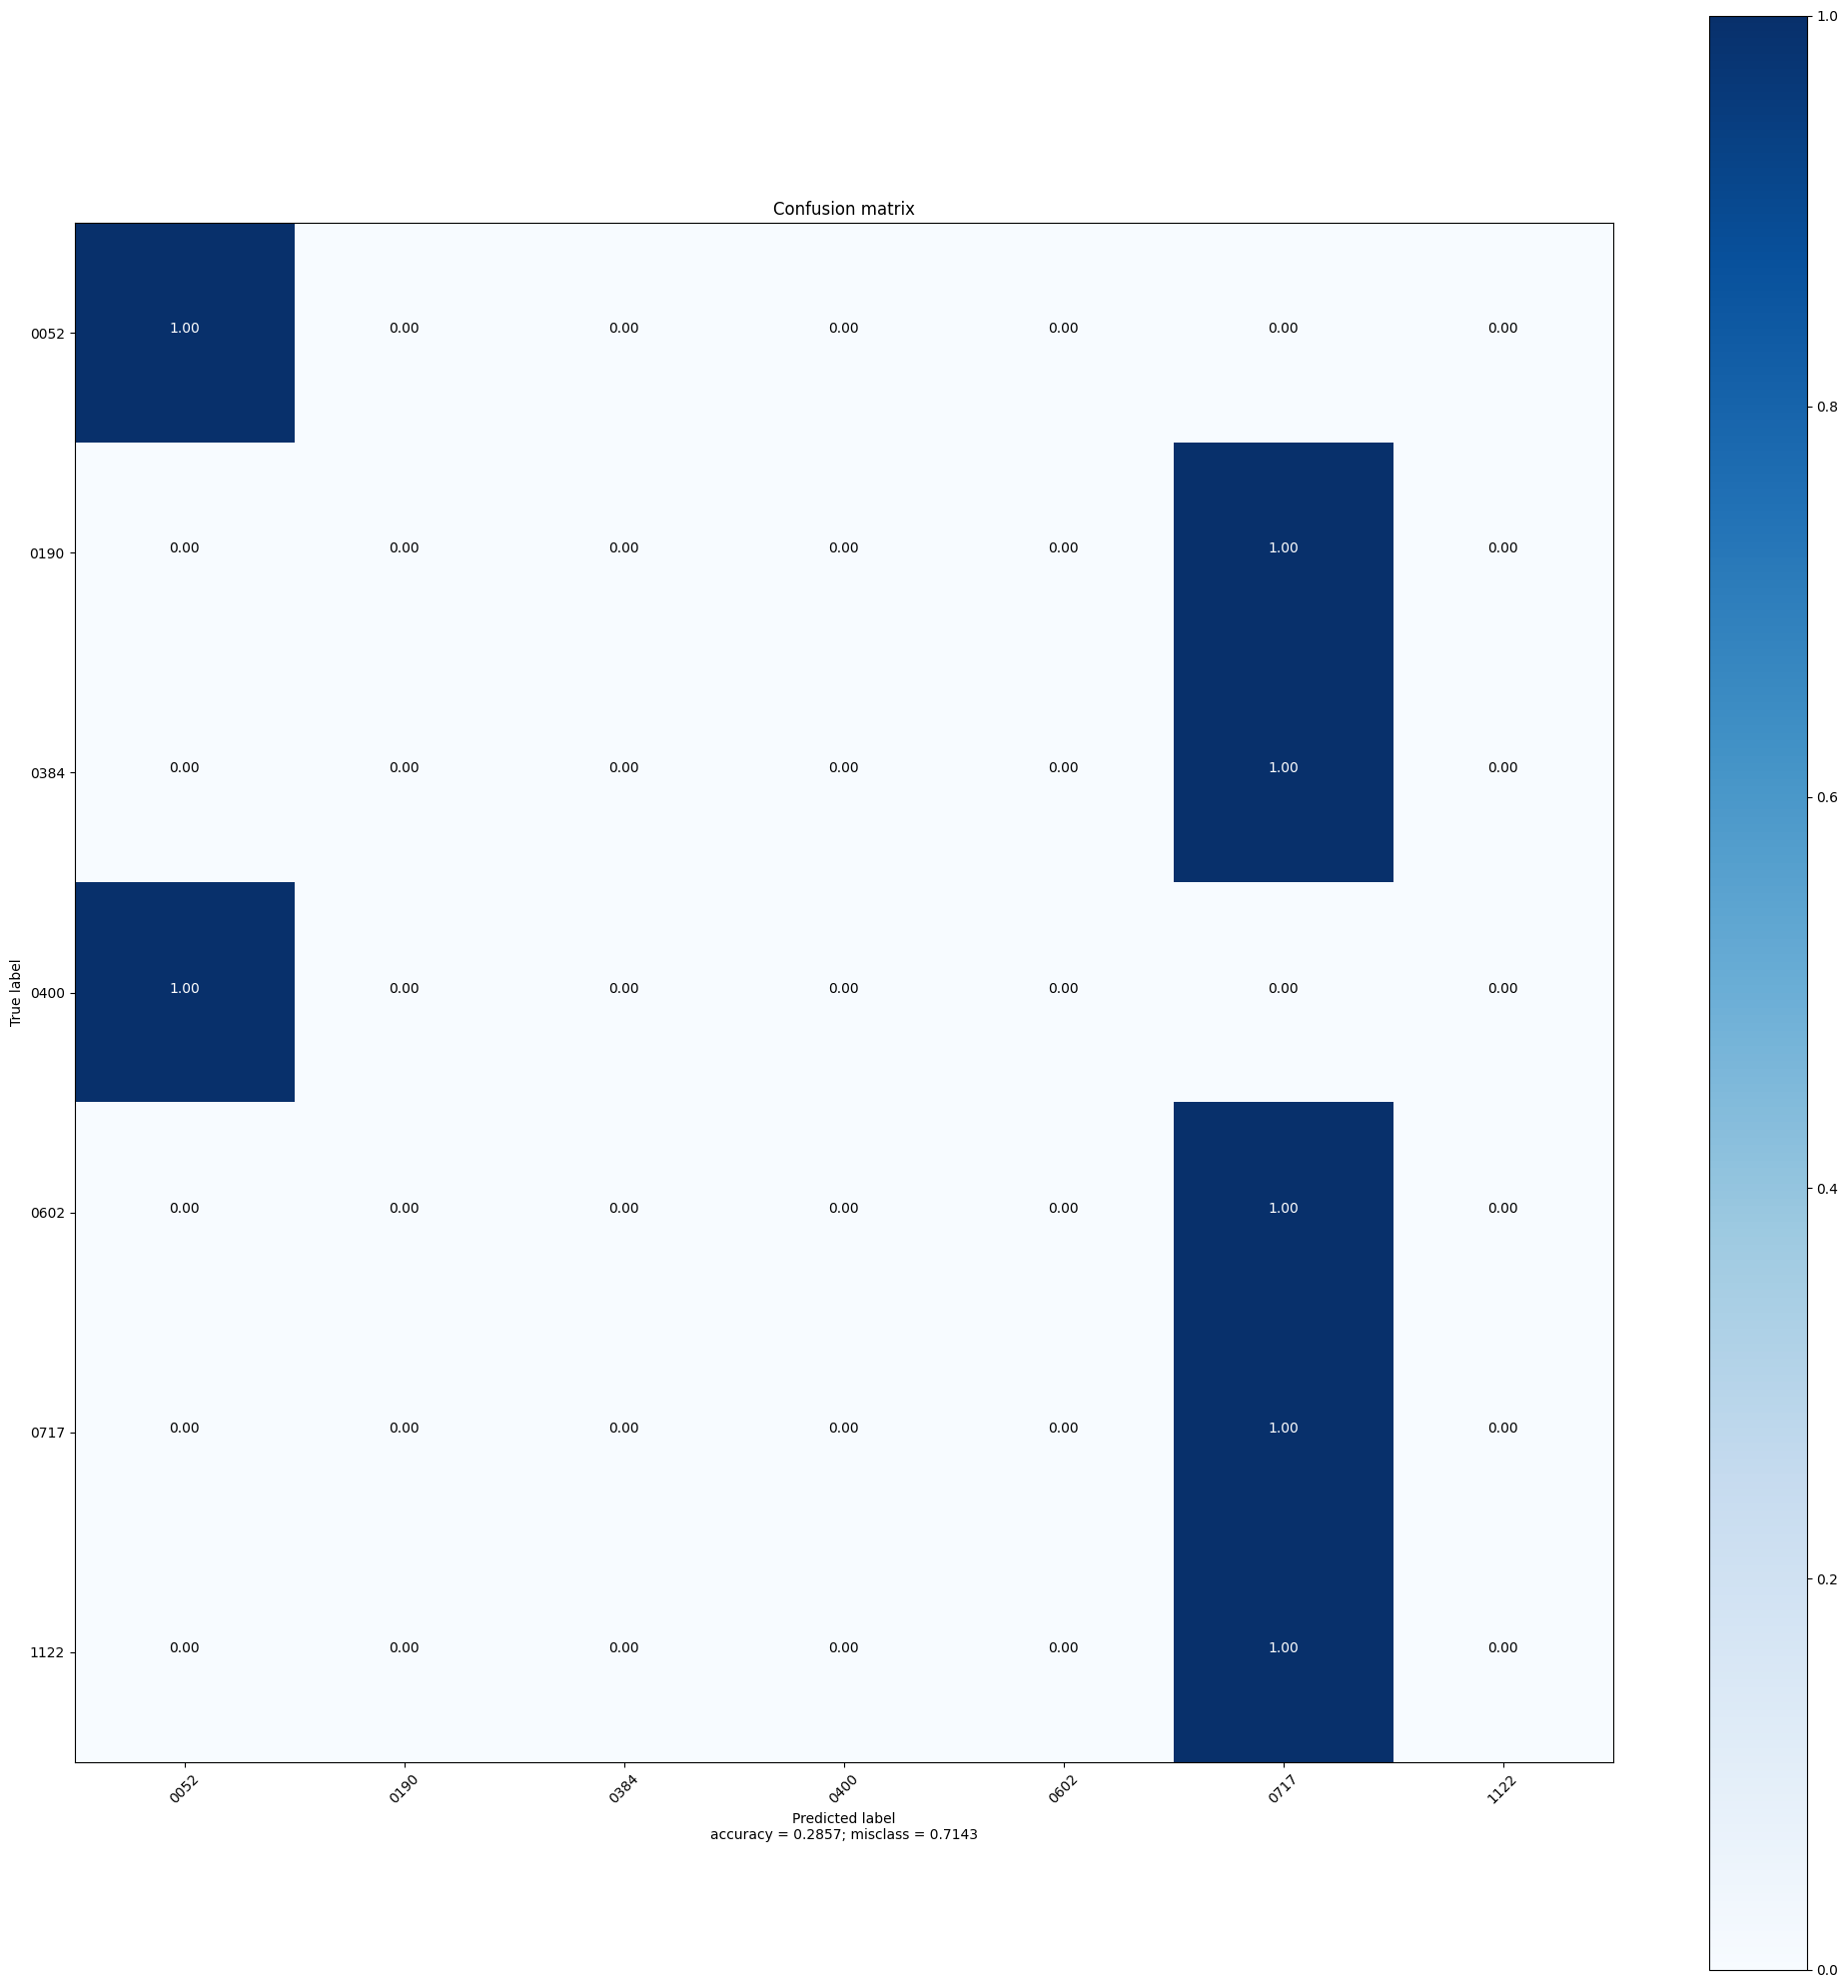

In [33]:
mean_, std_ = load_rgb_mean_std(f"{OUTPUT_DIR}/train")
dl = Standard_DataLoader(f"{OUTPUT_DIR}/test", 64, False, 'test', mean_, std_, True)
produce_classification_reports(dl, DEVICE, model, OUTPUT_DIR, TEST_ID)